In [1]:

import os, shutil
from glob import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')


In [2]:
in_dir = "out01_tms_induced_respose/"
in_dir2 = "data_subject_info/"

out_dir = "out02_two_sample_ttest_gender_and_boxplot_common_mask/"
in_file_name = "HRF_tms_induced_response_common_mask.csv"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
complete_df = pd.read_csv(in_dir + in_file_name)

subject_info = pd.read_csv(in_dir2 + "age_gender_edu.txt", sep = ',')
data = subject_info.merge(complete_df, left_on = 'cc_post_intake_id', right_on = 'subject')
data.drop(labels = ['inputfile', 'cc_post_intake_id'], axis = 1, inplace = True)
data.replace({'gender': {1: "male", 2: "female"}}, inplace = True)
data

,gender,age,yrs_of_edu,subject,site,group,tms_site_response_6mm,tms_site_response_10mm,tms_site_response_14mm,tms_site_response_14-10mm,tms_site_response_10-6mm
0,female,45,18,1001,L_Fp,NTHC,0.183782,0.223570,0.179095,0.151442,0.234871
1,female,45,18,1001,L_pMFG,NTHC,-0.444990,-0.412696,-0.310918,-0.256227,-0.406768
2,female,45,18,1001,R_FEF,NTHC,-0.311842,-0.273876,-0.276212,-0.277628,-0.262818
3,female,45,18,1001,R_Fp,NTHC,0.247076,0.241324,0.243161,0.244355,0.239672
4,female,45,18,1001,R_M1,NTHC,-0.916150,-1.146695,-1.232267,-1.289315,-1.221521
...,...,...,...,...,...,...,...,...,...,...,...
787,male,22,14,2108,R_IPL,TEHC,0.644515,1.131969,1.284253,1.393884,1.307835
788,male,22,14,2108,R_M1,TEHC,0.210817,0.194829,0.193421,0.192483,0.189640
789,male,22,14,2108,R_aMFG,TEHC,0.058481,-0.014030,-0.102940,-0.160327,-0.035552
790,male,22,14,2108,R_pMFG,TEHC,0.590151,0.451812,0.335860,0.267050,0.416303


In [3]:
## run 1 sample t-test for each roi:
pd.options.mode.chained_assignment = None # avoid the warnning message for assigning values to slices of df.
from scipy.stats import ttest_ind

def format_table(report):
    report2 = report.copy()
    report2[report.gt(0)] = report2[report.gt(0)].astype(str).apply(lambda x : x.str[:5])
    report2[report.lt(0)] = report2[report.lt(0)].astype(str).apply(lambda x : x.str[:6])
    
    report_pvalue = report2.iloc[1::3,:]
    report_pvalue[report.iloc[1::3,:].le(0.05)] = \
    report_pvalue[report.iloc[1::3,:].le(0.05)].apply(lambda x : x.str[:5]).add('*')

    report_pvalue = report2.iloc[1::3,:]
    report_pvalue[report.iloc[1::3,:].le(0.01)] = \
    report_pvalue[report.iloc[1::3,:].le(0.01)].apply(lambda x : x.str[:5]).add('**')
        
    return report2

test_variables = ['tms_site_response_6mm',
           'tms_site_response_10mm', 'tms_site_response_14mm', 
           'tms_site_response_14-10mm', 'tms_site_response_10-6mm']

plot_x_order = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

row_index = pd.MultiIndex.from_tuples([(i , j) for i in test_variables for j in ['t value', 'p value', "Cohen's d"]])
result = pd.DataFrame(index = row_index, columns = plot_x_order)

# statistical tests for each roi and roi setting:
for var in test_variables:
    for tms in plot_x_order:
        male = data.loc[(data['site']==tms) & (data['gender']=='male') & (~data[var].isna()), var]
        female = data.loc[(data['site']==tms) & (data['gender']=='female') & (~data[var].isna()), var]
        t, p = ttest_ind(male, female)
        
        cohend = (np.mean(male) - np.mean(female)) / (np.sqrt((np.std(male) ** 2 + np.std(female) ** 2) / 2))
        
        result.loc[(var, 't value'), tms] = t
        result.loc[(var, 'p value'), tms] = p
        result.loc[(var, "Cohen's d"), tms] = cohend

result = format_table(result)
# save results separately for each roi setting:
for var in test_variables:
    result.loc[(var, ['t value', 'p value', "Cohen's d"]), :].to_csv(out_dir + 'response_' + var + '.csv')

result.to_csv(out_dir + 'response_all.csv')
result.loc[(test_variables, ['p value', "Cohen's d"]),:]

L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  \
tms_site_response_6mm     p value    0.455   0.404  0.012*   0.858   0.667   
                          Cohen's d  0.193  -0.205   0.613   0.041   0.099   
tms_site_response_10mm    p value    0.306   0.398  0.020*   0.808   0.830   
                          Cohen's d  0.268  -0.210   0.572  -0.055   0.049   
tms_site_response_14mm    p value    0.292   0.438  0.025*   0.668   0.829   
                          Cohen's d  0.277  -0.194   0.558  -0.097  -0.050   
tms_site_response_14-10mm p value    0.313   0.481  0.030*   0.571   0.625   
                          Cohen's d  0.266  -0.177   0.539  -0.127  -0.113   
tms_site_response_10-6mm  p value    0.277   0.400  0.023*   0.699   0.868   
                          Cohen's d  0.286  -0.210   0.559  -0.088   0.038   

                                    R_pMFG   R_IFJ  R_FEF    R_M1 R_preSMA  \
tms_site_response_6mm     p value    0.532   0.598  0.409   0.981    0.321   
                          Cohen's d  0.143   0.124  0.188  -0.005    0.245   
tms_site_response_10mm    p value    0.297   0.860  0.362   0.908    0.250   
                          Cohen's d  0.242   0.041  0.209   0.026    0.288   
tms_site_response_14mm    p value    0.174   0.986  0.456   0.893    0.219   
                          Cohen's d  0.314  -0.003  0.173   0.030    0.309   
tms_site_response_14-10mm p value    0.125   0.875  0.543   0.883    0.206   
                          Cohen's d  0.352  -0.037  0.142   0.033    0.319   
tms_site_response_10-6mm  p value    0.254   0.962  0.357   0.873    0.239   
                          Cohen's d  0.265   0.011  0.212   0.036    0.297   

                                      R_IPL  
tms_site_response_6mm     p value     0.966  
                          Cohen's d  -0.012  
tms_site_response_10mm    p value     0.636  
                          Cohen's d   0.139  
tms_site_response_14mm    p value     0.370  
                          Cohen's d   0.266  
tms_site_response_14-10mm p value     0.231  
                          Cohen's d   0.358  
tms_site_response_10-6mm  p value     0.505  
                          Cohen's d   0.197

In [8]:
## boxplot of response (gender by site):

a4_dims = (12, 8)
tms_sites = complete_df['site'].unique()
plot_x_order = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(tms_sites)).as_hex()
colors = colors[1::2] + colors[2::2] 

def plot_response(ylabel, pvalue, cohend):

    fig, ax = plt.subplots(figsize=a4_dims, dpi=300)
    sns.swarmplot(y = ylabel, x = "site", data = data,
                  hue = 'gender', 
                  order=plot_x_order,
                  dodge=True, ax = ax, facecolors='none',
                  palette = colors, #plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75, size=4)

    sns.boxplot(y = ylabel, x = "site", data = data,
                hue = 'gender', 
                order=plot_x_order,
                palette = colors, notch = True, ax = ax)
    
    for i,artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # sns.boxplot(data=df,x="site",y="tms_site_response",dodge=True,showfliers=False,
                # showbox=True,linewidth=0.8,color = "w");
        
    # add annotations:
    locs, _ = plt.xticks()
    y = 3.5
    for i, x in enumerate(locs):
        ax.text(x-.3, y, "${p}$=" + pvalue[i], ha='left', va='bottom', color='k', size = 10)
        ax.text(x-.3, y+.3, "${d}$=" + cohend[i], ha='left', va='bottom', color='k', size = 10)
        
    
#     for legpatch in ax.get_legend().get_patches():
#         col = legpatch.get_facecolor()
#         legpatch.set_edgecolor('None')
#         legpatch.set_facecolor('None')
        
    handles, labels = ax.get_legend_handles_labels()
    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    l = ax.legend(handles[2:], labels[2:], borderaxespad=0., loc = 'lower right', columnspacing = 1.2,
                   frameon = False, markerscale =1.1, handlelength = .1,
                   prop = {'size': 10}, title = '', bbox_to_anchor=(.99, .15), ncol=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlim([-1, len(tms_sites)])
    ax.set_ylabel("Mean TMS Site Response")
    ax.set_xlabel("TMS Site");

    # Add horizontal red lines indicating mean of violinplot
#     spread = 0.1
#     for i, label in enumerate(ax.get_xticklabels()):
#         tms = label.get_text()
#         mean = np.nanmean(complete_df[complete_df['site']==str(tms)]['tms_site_response_standard'])
#         ax.hlines(mean, i-spread, i+spread, colors='red')
    ax.hlines(0, -1, len(tms_sites), linestyles='dotted', colors='grey')
    
    return fig

In [5]:
# fig = plot_response("tms_site_response_standard", result.loc[(var, 'p value'),:], result.loc[(var, "Cohen's d"),:])

tms_site_response_6mm


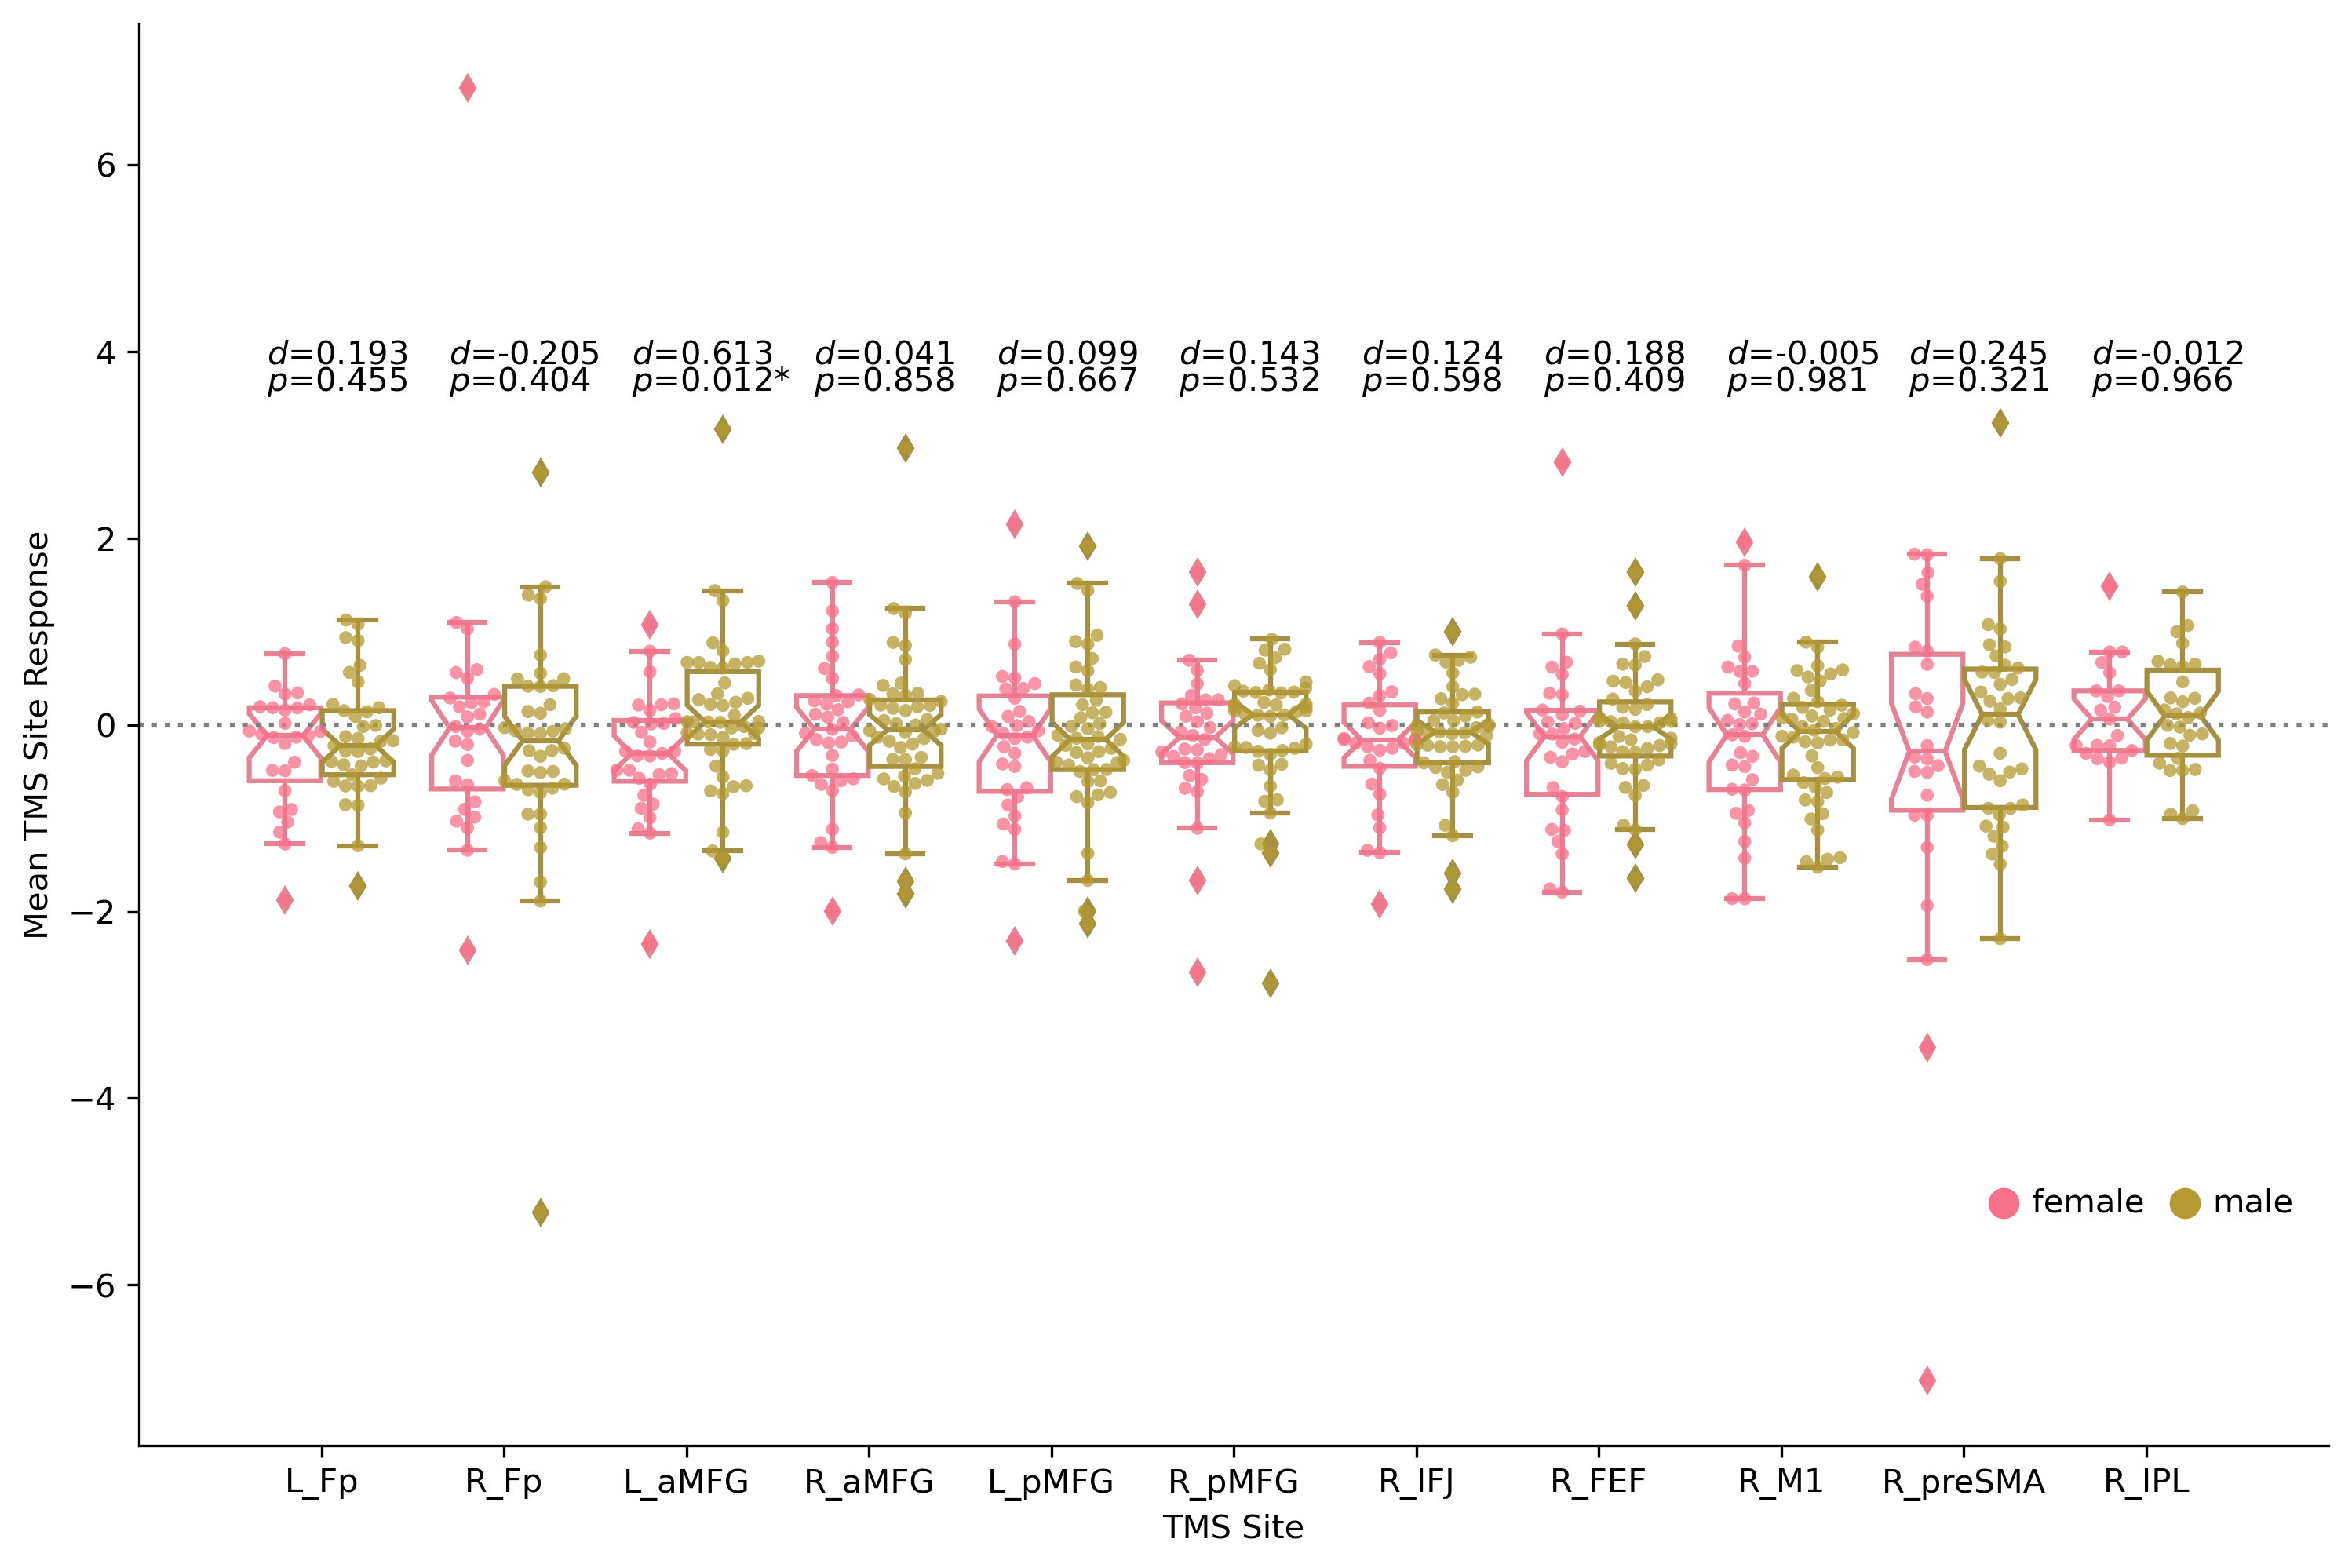

tms_site_response_10mm


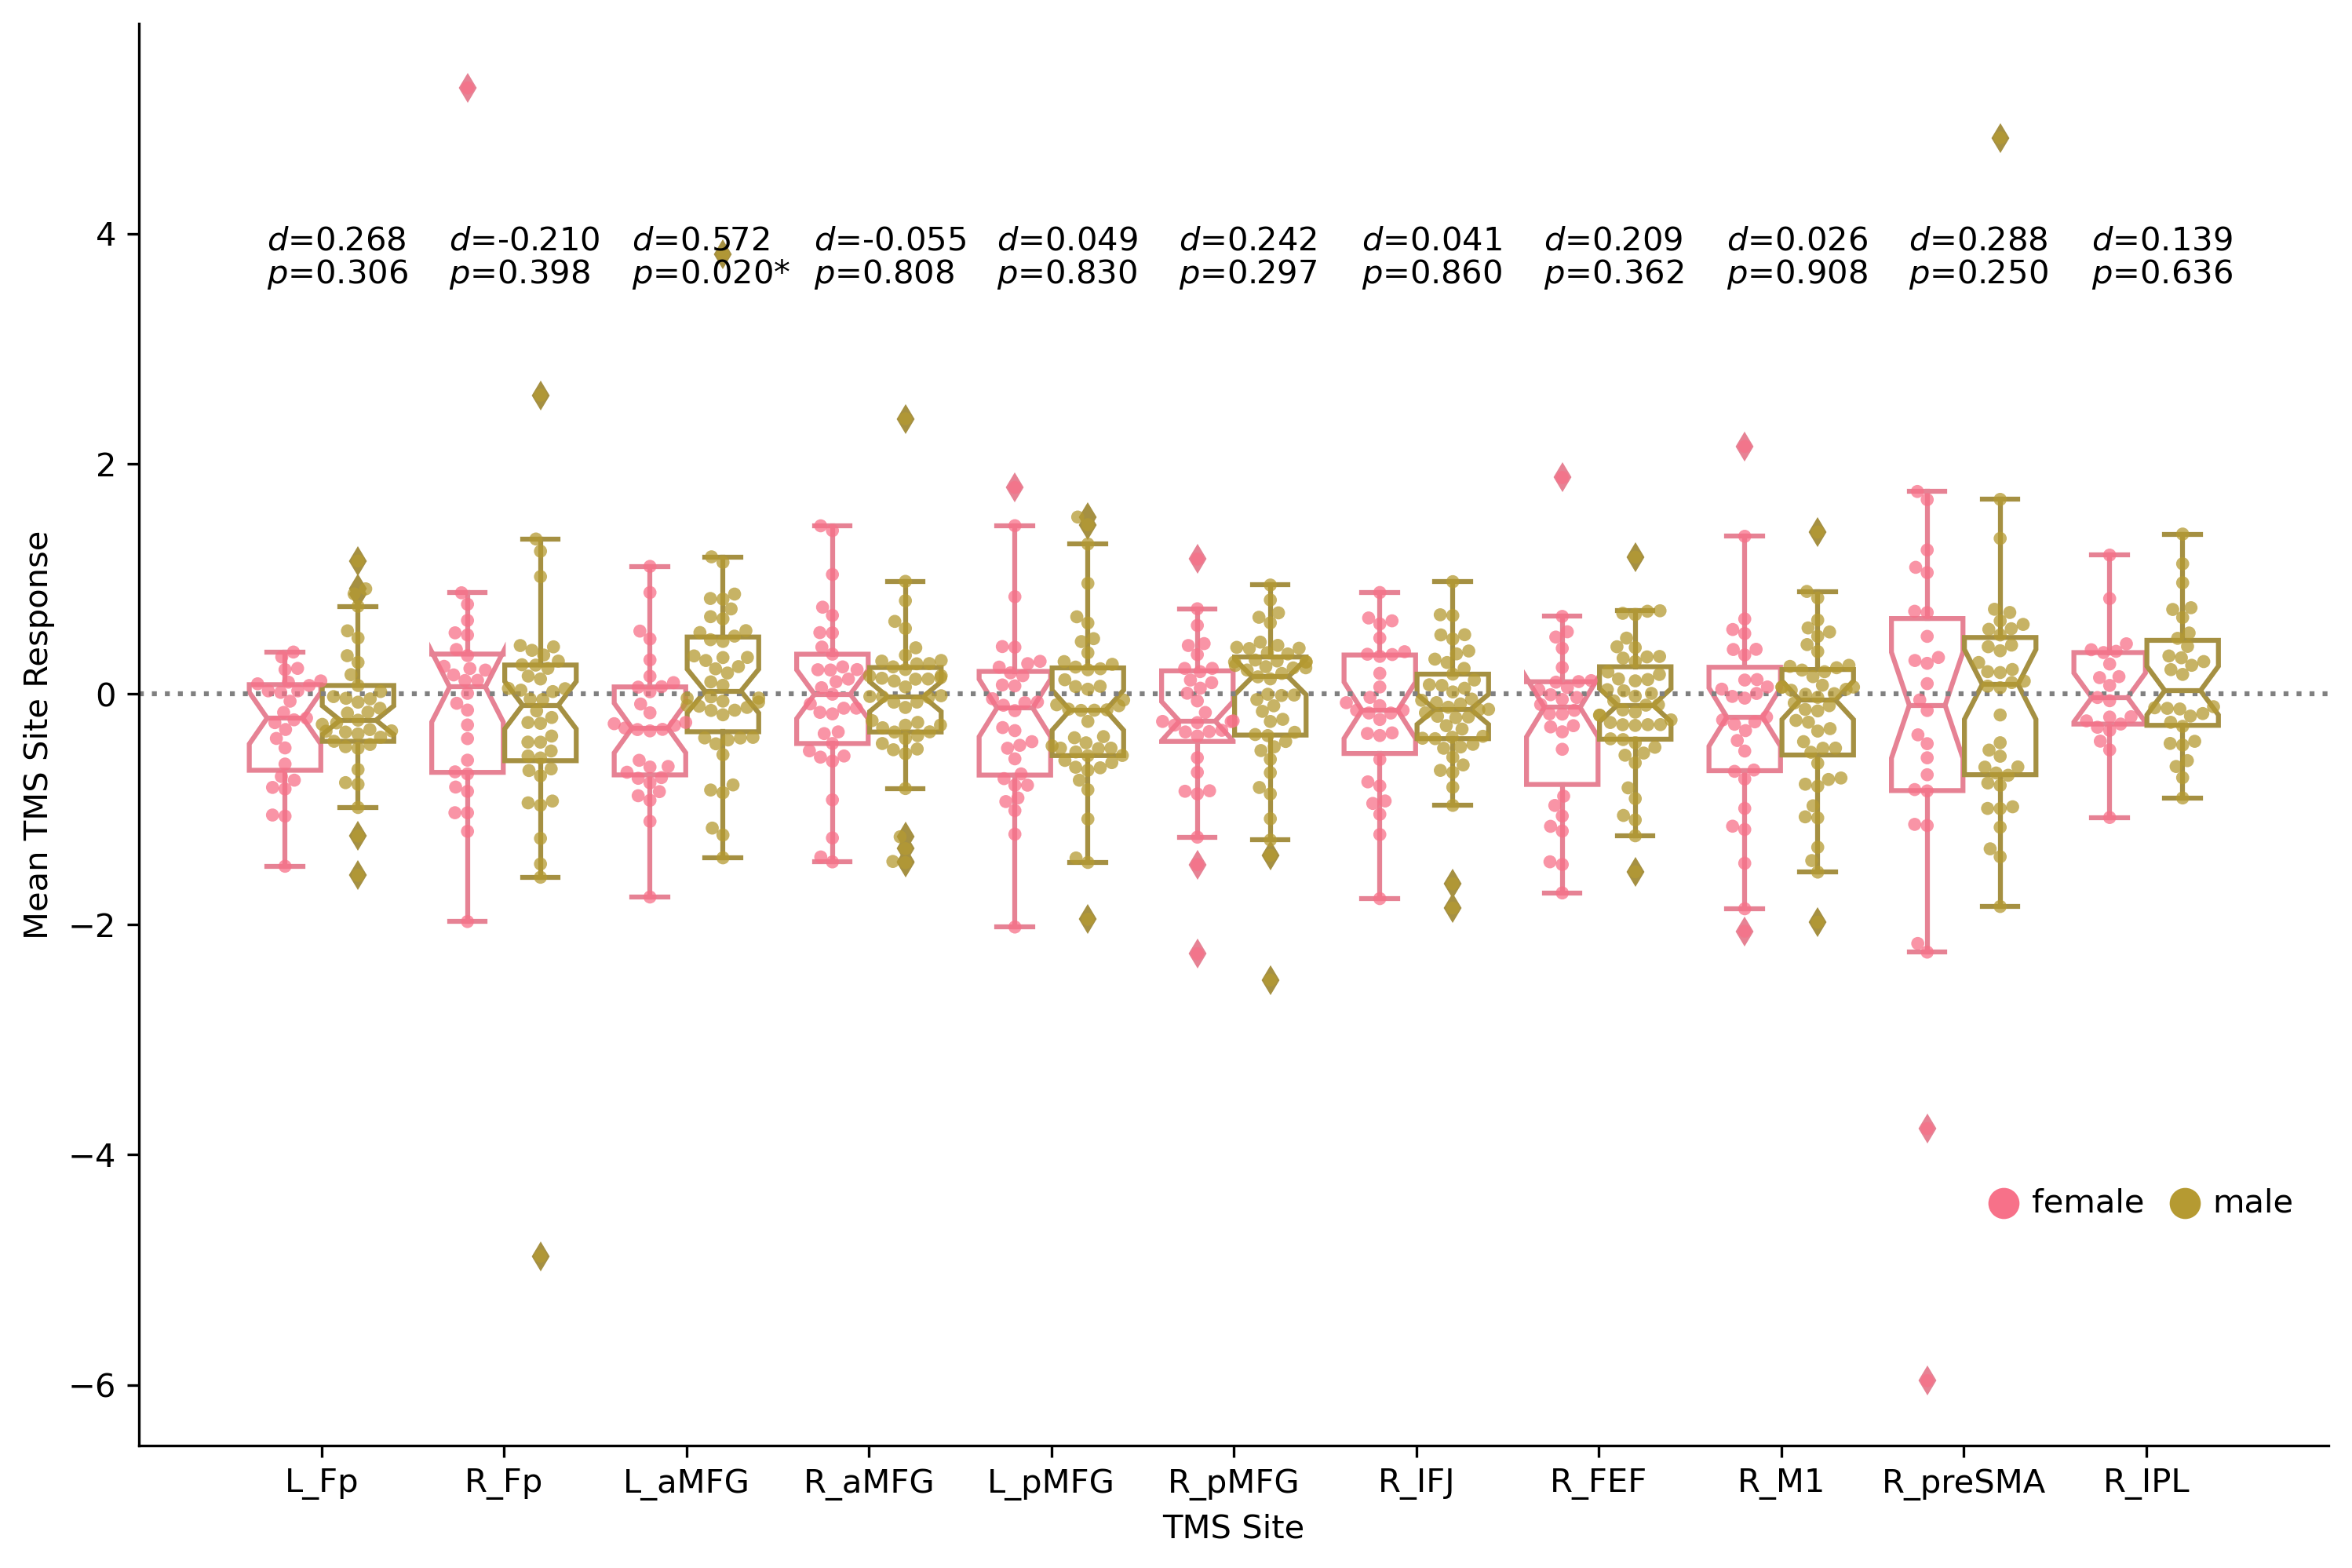

tms_site_response_14mm


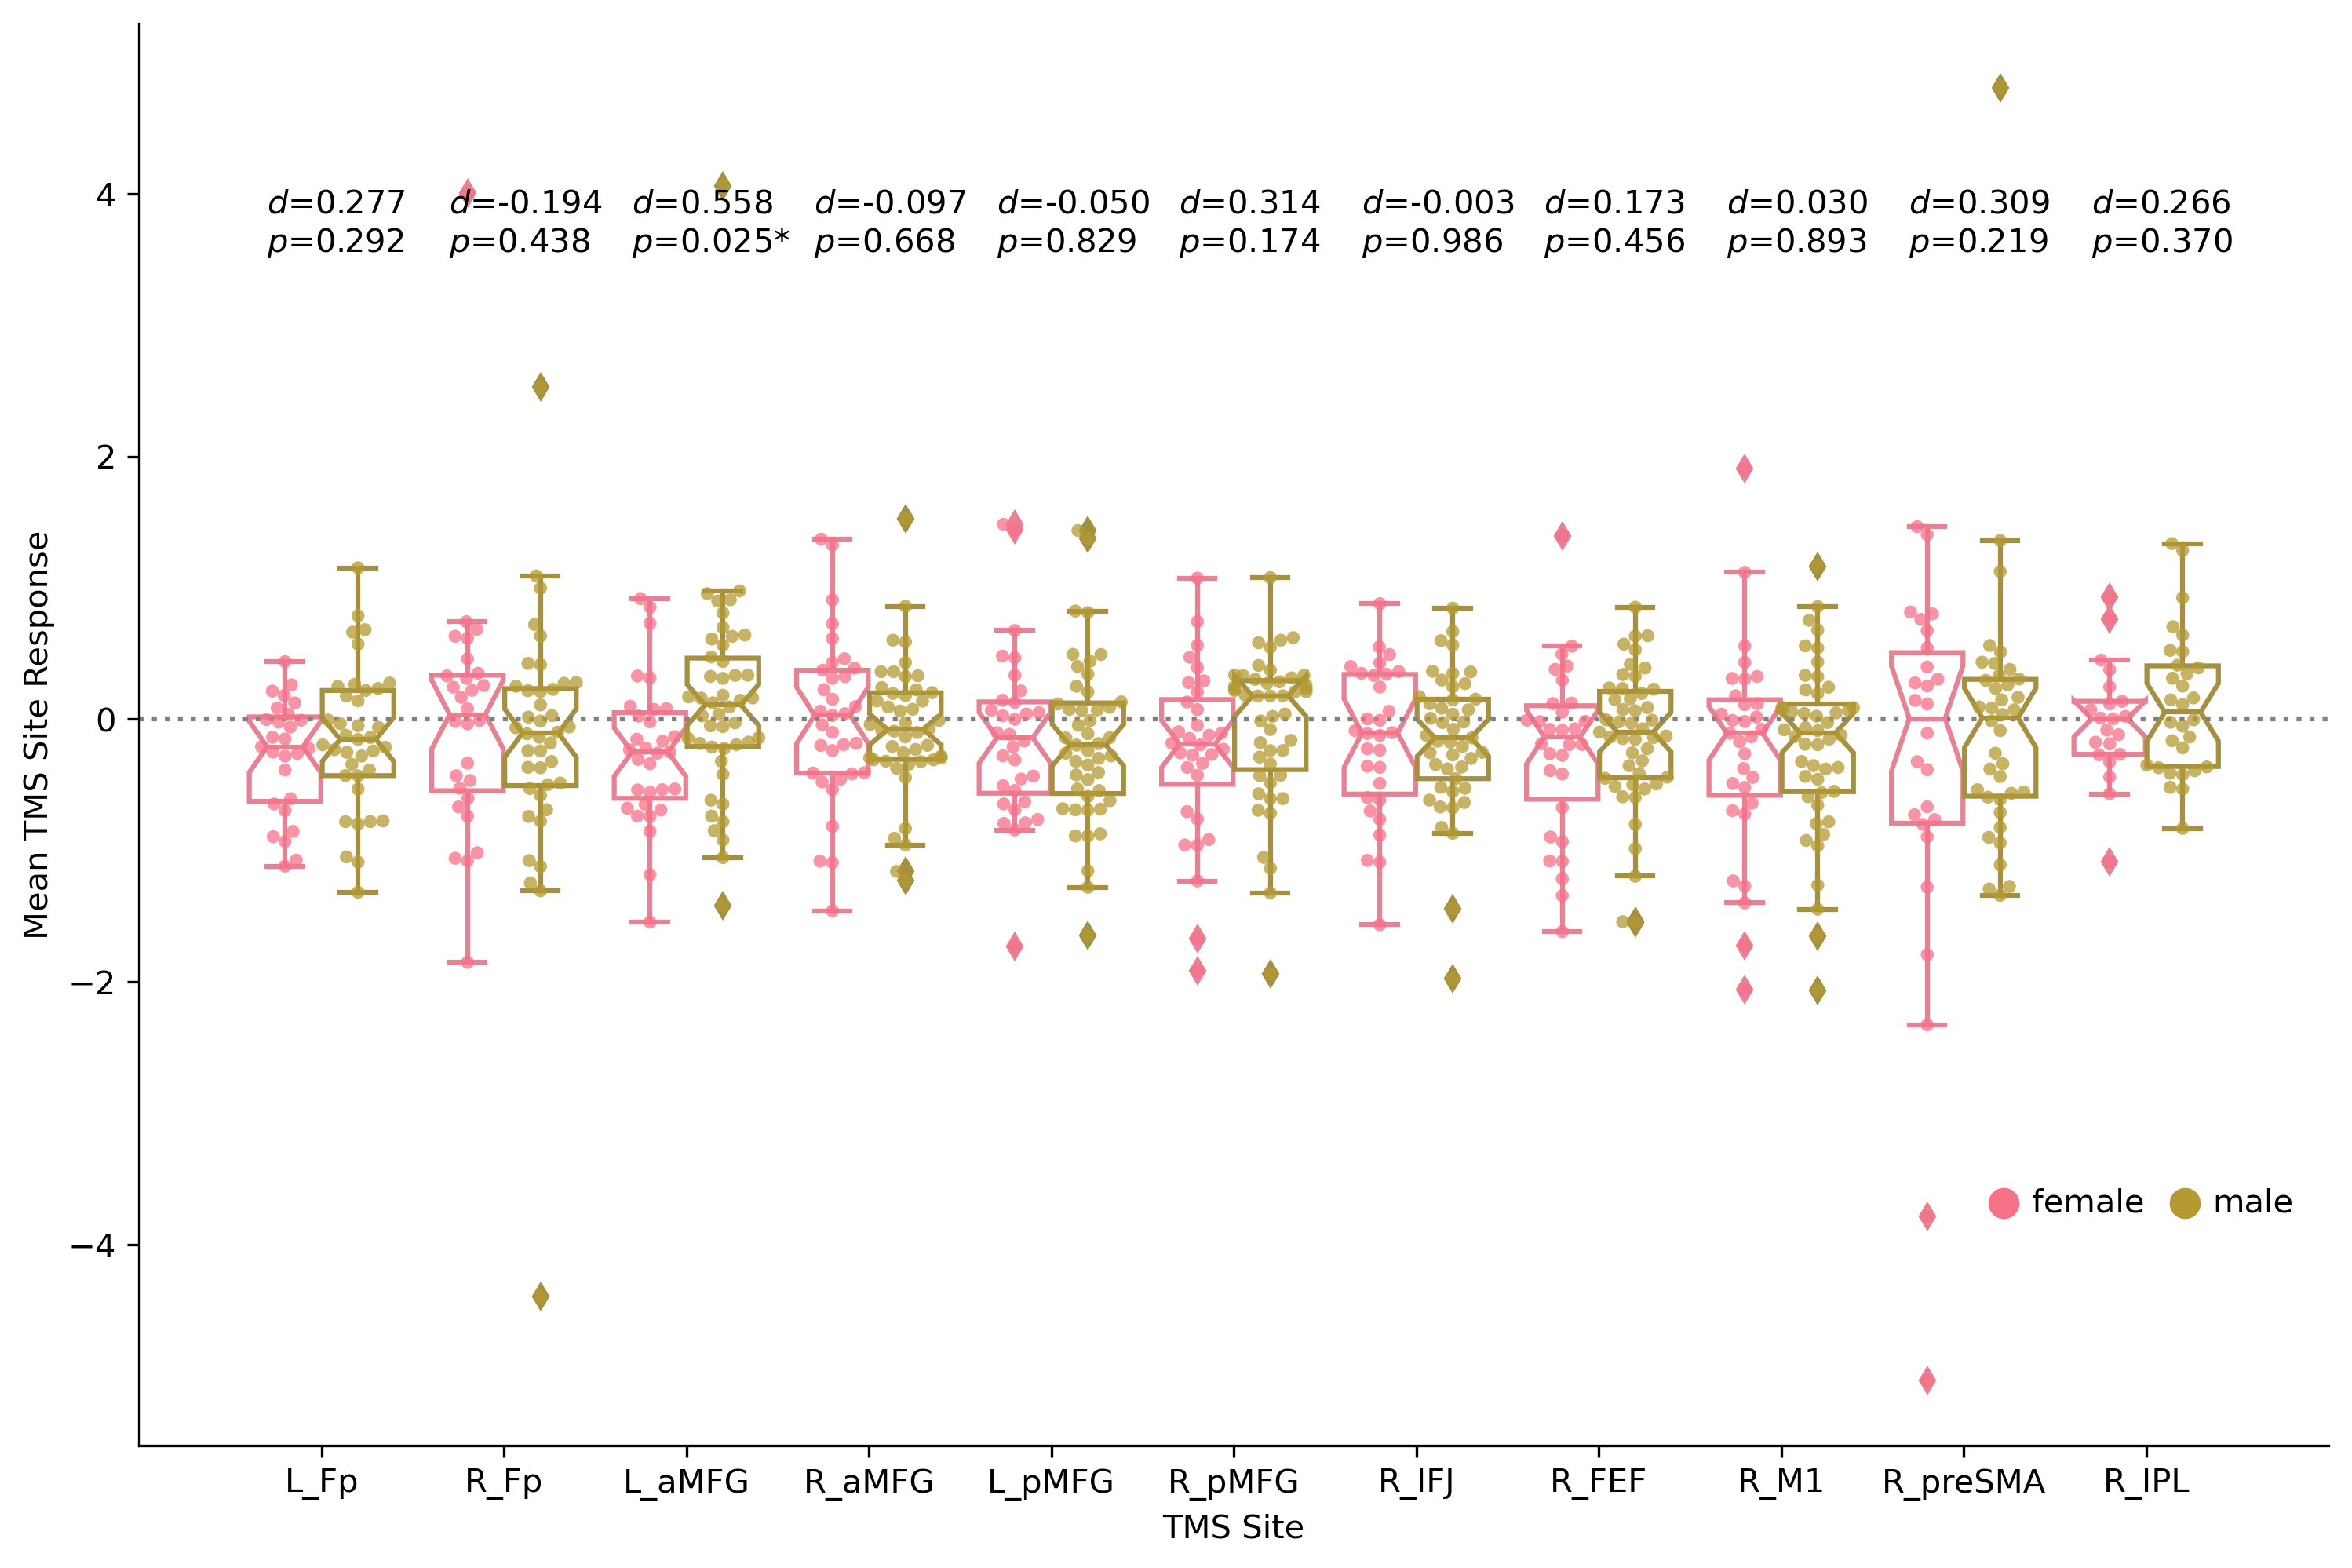

tms_site_response_14-10mm


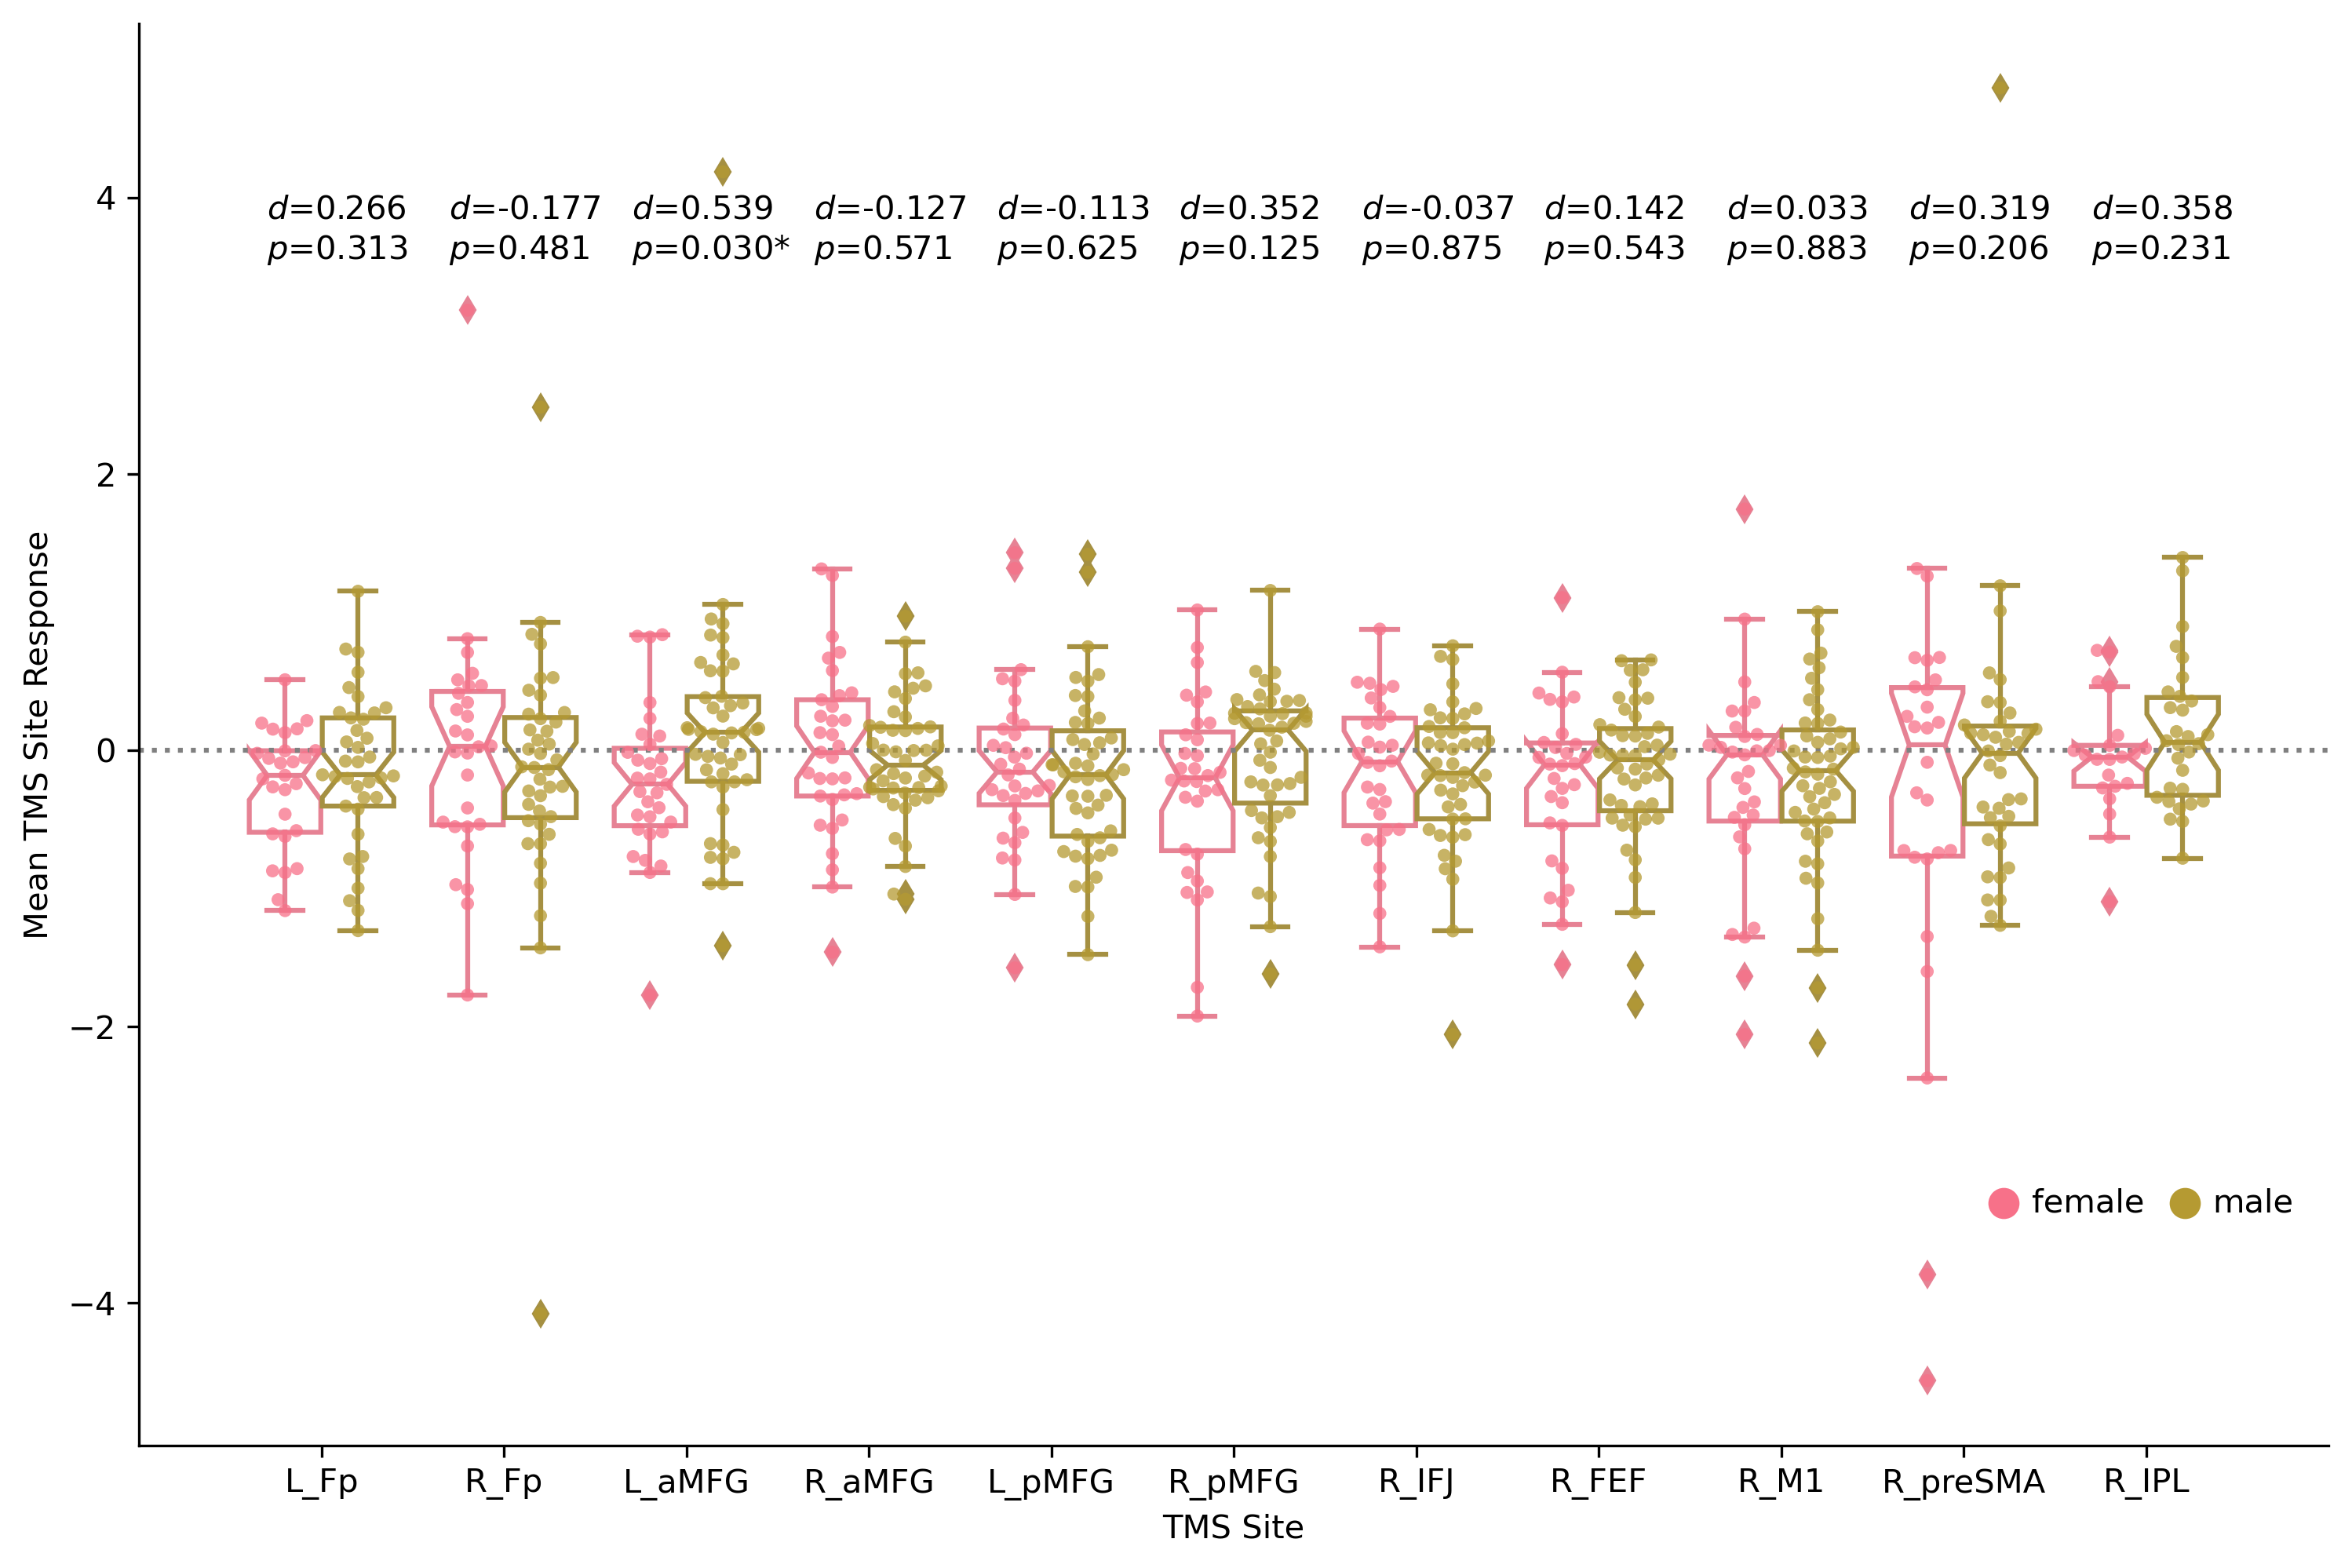

tms_site_response_10-6mm


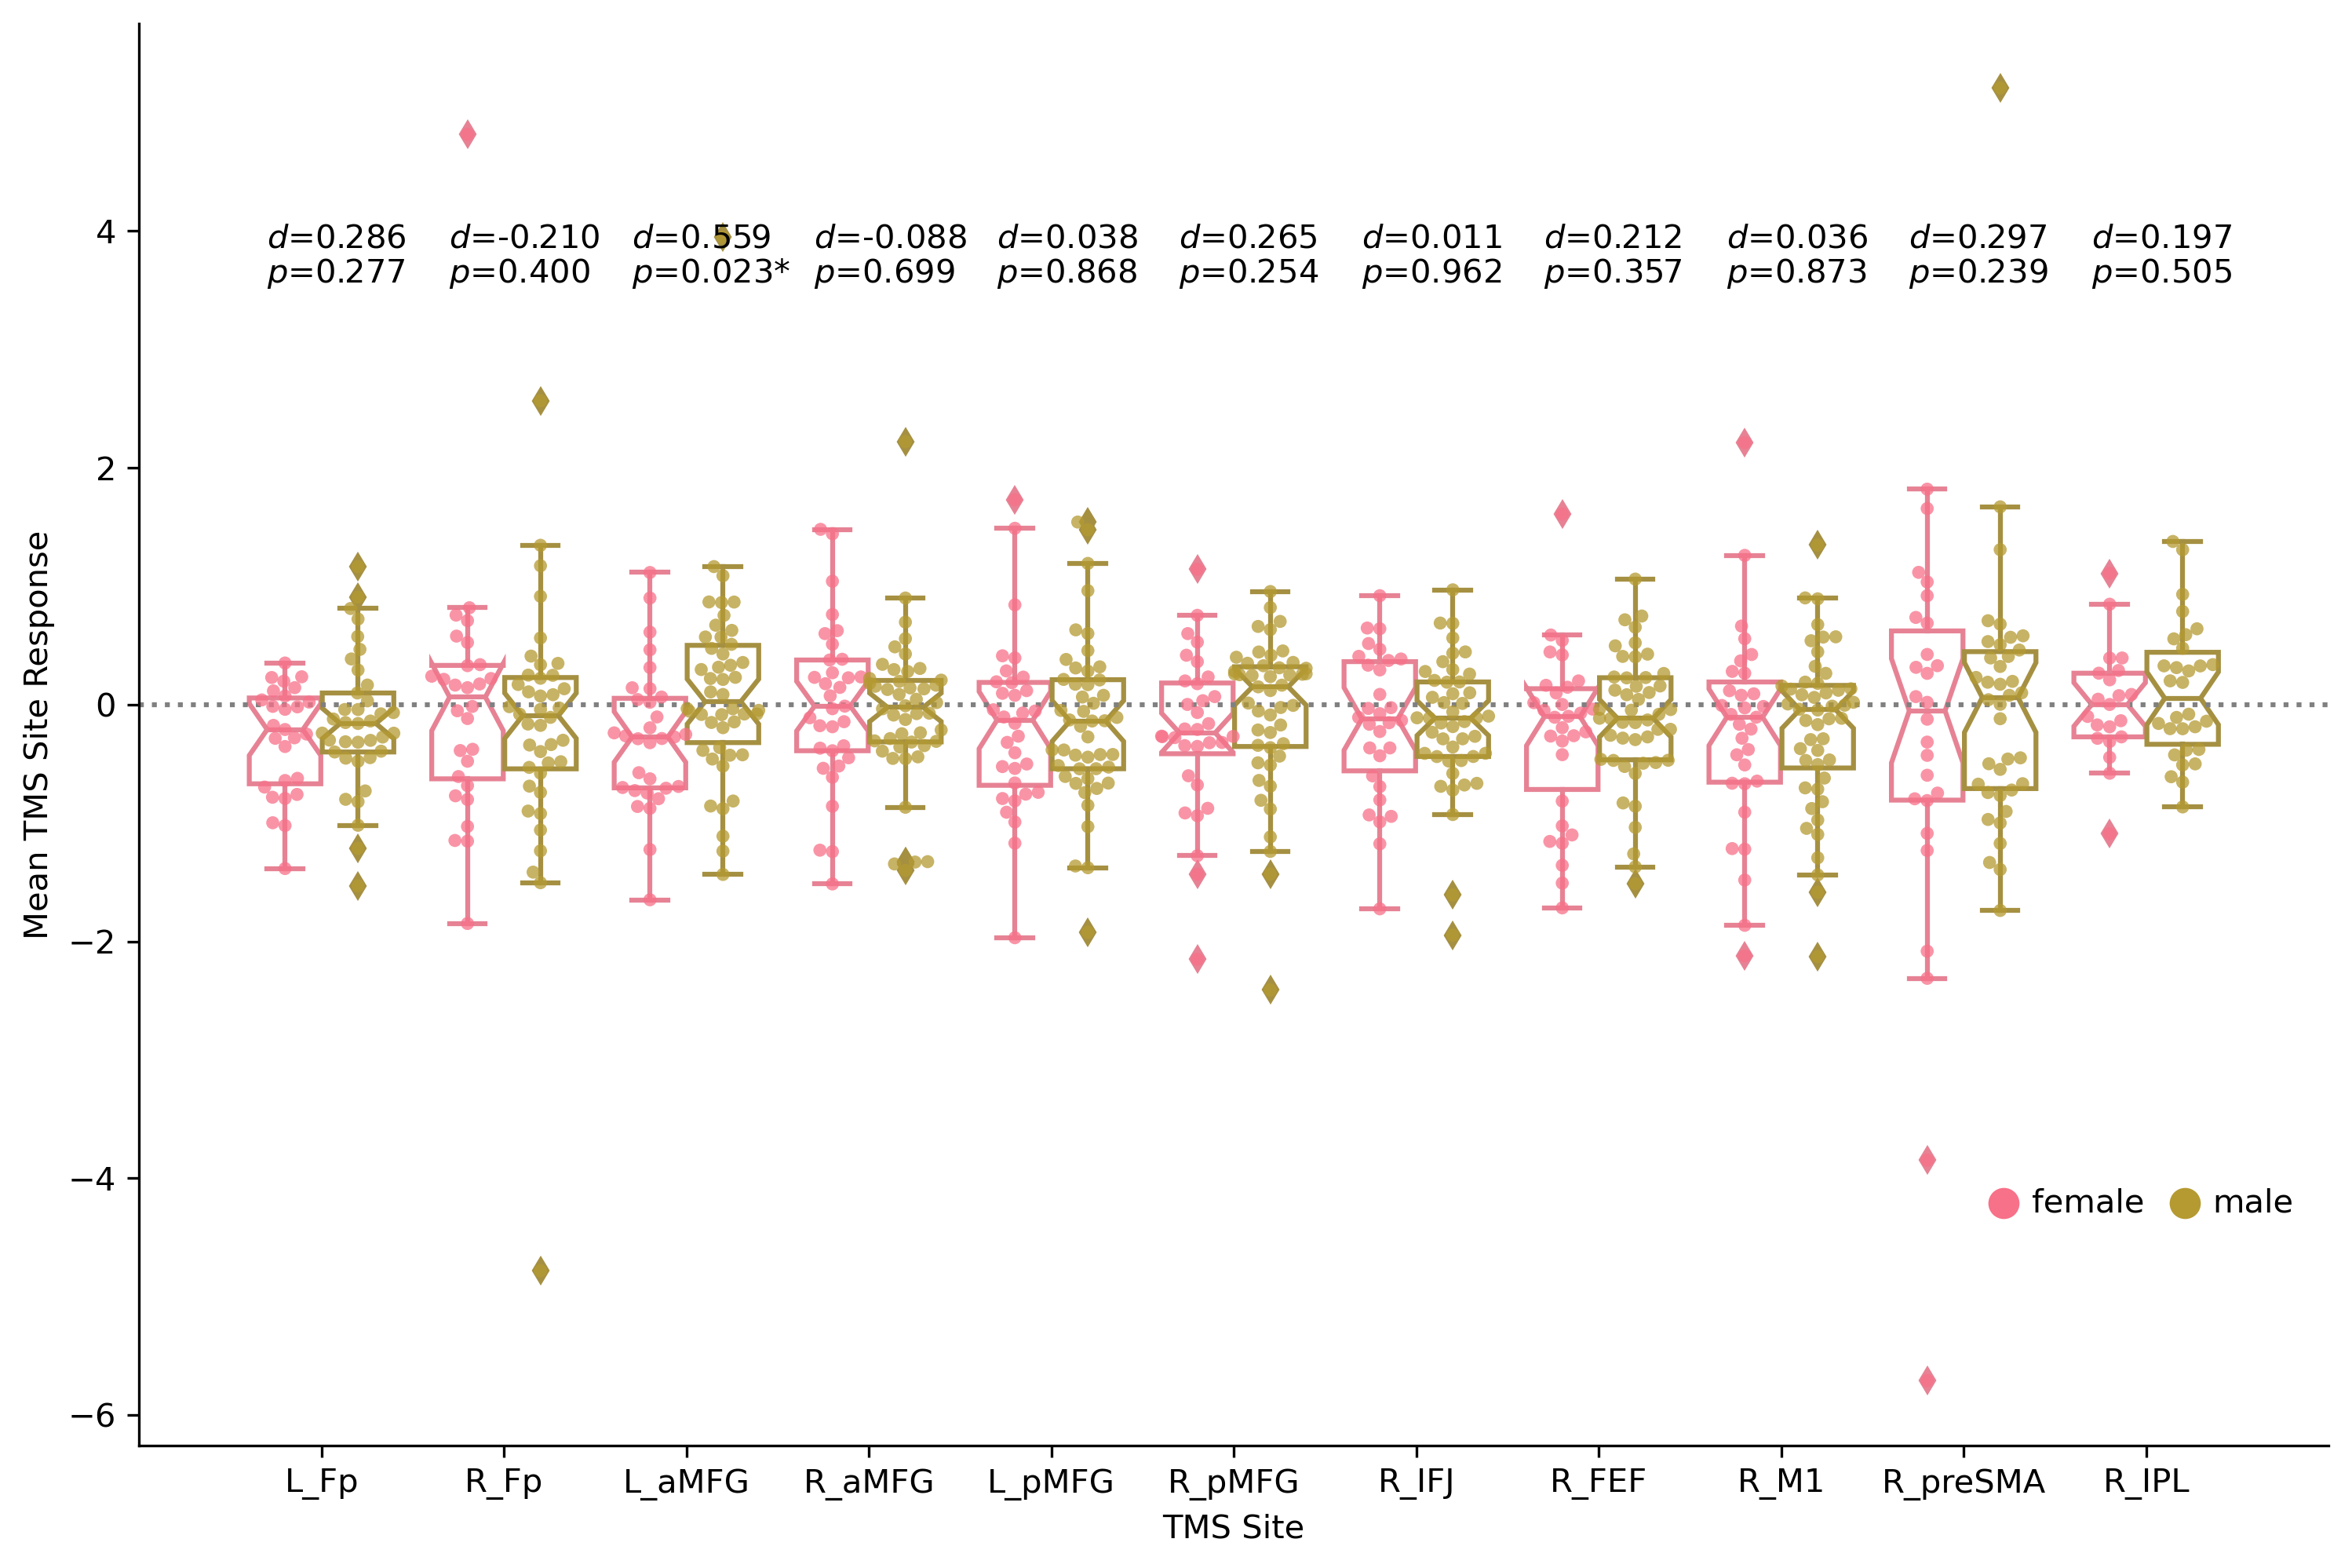

In [9]:

test_variables = ['tms_site_response_6mm',
           'tms_site_response_10mm', 'tms_site_response_14mm', 
           'tms_site_response_14-10mm', 'tms_site_response_10-6mm']

for var in test_variables:
    print(var)
    fig = plot_response(var, result.loc[(var, 'p value'),:], result.loc[(var, "Cohen's d"),:])
    plt.show()
    fig.savefig(out_dir+'/figure1_box_plot_tms_response' + var + '.png', dpi=600, 
                bbox_inches = 'tight', pad_inches = 0.1)
    